In [1]:
from keras.preprocessing import sequence
from keras.models import Sequential, Model, load_model
from keras.layers import GRU, Dense, Dropout, Input, concatenate
from keras.utils import np_utils
from keras.optimizers import Adam
import json, random, pickle, h5py
import pandas as pd
import numpy as np

/Users/pakpoom/anaconda3/envs/python27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# variable
words = [
    'come quickly', 'emergency', 'father', 'fever', 'good luck',
    'headache', 'hello', 'help', 'hi', 'hungry',
    'like', 'mother', 'mother_father', 'mother_mother', 'not ok',
    'quickly', 'sorry', 'tomorrow', 'yogurt'
]
data_per_word = 27
data_length = 2 * data_per_word * len(words)
timesteps = 50
dimensions = 22

In [3]:
def get_feature(frame):
    finger_name = ['thumb', 'index', 'middle', 'ring', 'pinky']
#     coordinate = ['x', 'y', 'z']
    fingertip_pos = np.zeros([2, 5, 3]) # [cooridinates x fingers]
    feature = np.zeros([22])
    hand_pos = np.zeros([12])
#     finger_tip = {}
    if 'right' in frame['hands']:
        hand_pos[0:6] = np.array([frame['hands']['right']['hand_palm_position'][0],
                                  frame['hands']['right']['hand_palm_position'][1],
                                  frame['hands']['right']['hand_palm_position'][2],
                                  frame['hands']['right']['yaw'], 
                                  frame['hands']['right']['roll'], 
                                  frame['hands']['right']['pitch']])
        for idx, finger in enumerate(finger_name):
#             fingertip_pos[2 + idx, :] = np.array(frame['hands']['right']['fingers'][finger]['bones']['distal']['next_joint'])
            fingertip_pos[0, idx, :] = np.array(frame['hands']['right']['fingers'][finger]['bones']['distal']['next_joint'])
    if 'left' in frame['hands']:
        hand_pos[6:12] = np.array([frame['hands']['left']['hand_palm_position'][0],
                                   frame['hands']['left']['hand_palm_position'][1],
                                   frame['hands']['left']['hand_palm_position'][2],
                                   frame['hands']['left']['yaw'], 
                                   frame['hands']['left']['roll'], 
                                   frame['hands']['left']['pitch']])
#         fingertip_pos[8, :] = np.array(frame['hands']['left']['hand_palm_position'])
        for idx, finger in enumerate(finger_name):
#             fingertip_pos[4 + 5 + idx, :] = np.array(frame['hands']['left']['fingers'][finger]['bones']['distal']['next_joint'])
            fingertip_pos[1, idx, :] = np.array(frame['hands']['left']['fingers'][finger]['bones']['distal']['next_joint'])
    fingertip_pos_shift = np.roll(fingertip_pos, 1, axis=1)
    feature[0:10] = np.linalg.norm(fingertip_pos - fingertip_pos_shift, axis=2).reshape(10)
    feature[10:22] = hand_pos

    return feature

In [4]:
max_frame = 0
for word_no, word in enumerate(words):
    for data_no in range(data_per_word):
        try:
            with open("./record/{}/json_{}.txt".format(word, data_no)) as json_data:
                json_data = json.load(json_data)
        except Exception as s:
            print ('error log:', s)
        
        if max_frame < len(json_data):
            max_frame = len(json_data)

In [5]:
pick_frame_every_no = max_frame / 50 + 1

In [6]:
x = np.zeros([data_length, timesteps, dimensions])
y = np.zeros([data_length])
for word_no, word in enumerate(words):
    for data_no in range(data_per_word):
        try:
            with open("./record/{}/json_{}.txt".format(word, data_no)) as json_data:
                json_data = json.load(json_data)
        except Exception as s:
            print ('error log:', s)
        
        curr_idx = 0
        
        for frame_no, frame in enumerate(json_data):
            if frame_no % pick_frame_every_no != 0 or not frame['hands']: #check if frame[hands] is null
                continue
            feature = get_feature(frame)
#             for idx, fingertip_pos in enumerate(fingertips_pos):
            x[2 * ((word_no * data_per_word) + data_no), curr_idx, :] = feature
            curr_idx += 1

        y[2 * ((word_no * data_per_word) + data_no)] = word_no
#         print((word_no * data_per_word * 2) + data_no)
        del_idx = range(0, len(json_data), pick_frame_every_no)
        json_data_speedup = np.delete(json_data, del_idx)
        
        curr_idx = 0
        
        for frame_no, frame in enumerate(json_data_speedup):
            if frame_no % pick_frame_every_no != 0 or not frame['hands']: #check if frame[hands] is null
                continue
            feature = get_feature(frame)
#             for idx, fingertip_pos in enumerate(fingertips_pos):
            x[(word_no * data_per_word * 2) + data_per_word + data_no, curr_idx, :] = feature
            curr_idx += 1

        y[(word_no * data_per_word * 2) + data_per_word + data_no] = word_no
#         print((word_no * data_per_word * 2) + 1 + data_no)
#         print('___')

In [7]:
x_std = x.std(axis=(0,1), keepdims=True)
x_mean = x.mean(axis=(0,1), keepdims=True)
x_norm = (x-x_mean)/x_std
# x_norm = (x-x_min)/(x_max-x_min)
# x_norm = 2*(x-(x_max+x_min)/2)/(x_max-x_min)

In [8]:
x_train = np.zeros([data_length * 4 / 6, timesteps, dimensions])
y_train = np.zeros([data_length * 4 / 6])
x_test = np.zeros([data_length / 6, timesteps, dimensions])
y_test = np.zeros([data_length / 6])
x_valid = np.zeros([data_length / 6, timesteps, dimensions])
y_valid = np.zeros([data_length / 6])
train_count = test_count = valid_count = 0

for idx in range(data_length):
    if idx % 6 == 0:
        test_idx = random.sample(xrange(6), 1)
        valid_idx = random.sample(xrange(6), 1)
        while valid_idx == test_idx:
            valid_idx = random.sample(xrange(6), 1)
#         print('rand', test_idx, valid_idx)
    if idx % 6 == test_idx[0]:
#         print('test', test_count, idx)
        x_test[test_count] = x_norm[idx]
        y_test[test_count] = y[idx]
        test_count += 1
    elif idx % 6 == valid_idx[0]:
#         print('valid', valid_count, idx)
        x_valid[valid_count] = x_norm[idx]
        y_valid[valid_count] = y[idx]
        valid_count += 1
    else:
#         print('train', train_count, idx)
        x_train[train_count] = x_norm[idx]
        y_train[train_count] = y[idx]
        train_count += 1

In [9]:
shuffle_train = np.arange(len(x_train))
np.random.shuffle(shuffle_train)
x_train_shuffle = np.zeros([data_length * 4 / 6, timesteps, dimensions])
y_train_shuffle = np.zeros([data_length * 4 / 6])
for idx, item in enumerate(shuffle_train):
    x_train_shuffle[idx] = x_train[item]
    y_train_shuffle[idx] = y_train[item]

In [10]:
# encoding label
Y_train_shuffle = np_utils.to_categorical(y_train_shuffle, len(words))
Y_test = np_utils.to_categorical(y_test, len(words))
Y_valid = np_utils.to_categorical(y_valid, len(words))

In [24]:
fingers = Input(shape=(timesteps, dimensions), name='fingers')
fingers_layers = GRU(64, activation='tanh', recurrent_activation='hard_sigmoid', dropout=0.2, recurrent_dropout=0.2)(fingers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
output_layer = Dense(len(words), activation='softmax')(fingers_layers)
model = Model(inputs=fingers, outputs=output_layer)
adam = Adam(lr=0.01, decay=0.0001)
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
history = model.fit(x_train_shuffle, Y_train_shuffle,validation_data=(x_valid, Y_valid), epochs=500, batch_size=64, shuffle=True)
# model.save_weights("model_weight.h5")
model.save("./history/model223181411.h5")
with open('./history/history223181411.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Train on 684 samples, validate on 171 samples
Epoch 1/500
684/684 [==============================] - 3s 4ms/step - loss: 2.8311 - acc: 0.2515 - val_loss: 2.6967 - val_acc: 0.2865
Epoch 2/500
684/684 [==============================] - 1s 813us/step - loss: 2.7327 - acc: 0.2822 - val_loss: 2.6701 - val_acc: 0.2865
Epoch 3/500
684/684 [==============================] - 1s 814us/step - loss: 2.7224 - acc: 0.2822 - val_loss: 2.6706 - val_acc: 0.2865
Epoch 4/500
684/684 [==============================] - 1s 839us/step - loss: 2.7062 - acc: 0.2822 - val_loss: 2.6909 - val_acc: 0.2865
Epoch 5/500
684/684 [==============================] - 1s 823us/step - loss: 2.7077 - acc: 0.2822 - val_loss: 2.6955 - val_acc: 0.2865
Epoch 6/500
684/684 [==============================] - 1s 799us/step - loss: 2.6876 - acc: 0.2822 - val_loss: 2.6241 - val_acc: 0.2865
Epoch 7/500
684/684 [==============================] - 1s 814us/step - loss: 2.4573 - acc: 0.2865 - val_loss: 2.2214 - val_acc: 0.2865
Epoch 8/500

684/684 [==============================] - 1s 761us/step - loss: 0.8534 - acc: 0.6842 - val_loss: 0.7500 - val_acc: 0.7719
Epoch 62/500
684/684 [==============================] - 1s 809us/step - loss: 0.8755 - acc: 0.6740 - val_loss: 0.7813 - val_acc: 0.7368
Epoch 63/500
684/684 [==============================] - 1s 852us/step - loss: 0.8529 - acc: 0.6871 - val_loss: 0.7265 - val_acc: 0.7719
Epoch 64/500
684/684 [==============================] - 1s 814us/step - loss: 0.9427 - acc: 0.6681 - val_loss: 0.7626 - val_acc: 0.7661
Epoch 65/500
684/684 [==============================] - 1s 755us/step - loss: 0.8875 - acc: 0.6594 - val_loss: 0.8148 - val_acc: 0.7251
Epoch 66/500
684/684 [==============================] - 1s 796us/step - loss: 0.9099 - acc: 0.6871 - val_loss: 0.7297 - val_acc: 0.7602
Epoch 67/500
684/684 [==============================] - 1s 804us/step - loss: 0.8783 - acc: 0.6827 - val_loss: 0.7337 - val_acc: 0.7661
Epoch 68/500
684/684 [==============================] - 1s 80

684/684 [==============================] - 1s 812us/step - loss: 0.6909 - acc: 0.7544 - val_loss: 0.6578 - val_acc: 0.8129
Epoch 122/500
684/684 [==============================] - 1s 810us/step - loss: 0.7596 - acc: 0.7368 - val_loss: 0.7316 - val_acc: 0.7953
Epoch 123/500
684/684 [==============================] - 1s 781us/step - loss: 0.7356 - acc: 0.7266 - val_loss: 0.7062 - val_acc: 0.7719
Epoch 124/500
684/684 [==============================] - 1s 794us/step - loss: 0.6954 - acc: 0.7573 - val_loss: 0.6591 - val_acc: 0.8363
Epoch 125/500
684/684 [==============================] - 1s 790us/step - loss: 0.8033 - acc: 0.7325 - val_loss: 0.7512 - val_acc: 0.8012
Epoch 126/500
684/684 [==============================] - 1s 794us/step - loss: 0.7835 - acc: 0.7105 - val_loss: 0.6646 - val_acc: 0.8538
Epoch 127/500
684/684 [==============================] - 1s 777us/step - loss: 0.8134 - acc: 0.7120 - val_loss: 0.7210 - val_acc: 0.7895
Epoch 128/500
684/684 [==============================] 

Epoch 181/500
684/684 [==============================] - 1s 895us/step - loss: 0.6392 - acc: 0.7939 - val_loss: 0.5904 - val_acc: 0.8596
Epoch 182/500
684/684 [==============================] - 1s 889us/step - loss: 0.7460 - acc: 0.7705 - val_loss: 0.7214 - val_acc: 0.7953
Epoch 183/500
684/684 [==============================] - 1s 767us/step - loss: 0.6953 - acc: 0.7646 - val_loss: 0.6694 - val_acc: 0.7953
Epoch 184/500
684/684 [==============================] - 1s 776us/step - loss: 0.6911 - acc: 0.7705 - val_loss: 0.6324 - val_acc: 0.8129
Epoch 185/500
684/684 [==============================] - 1s 1ms/step - loss: 0.6621 - acc: 0.7719 - val_loss: 0.6017 - val_acc: 0.8363
Epoch 186/500
684/684 [==============================] - 1s 918us/step - loss: 0.6571 - acc: 0.7851 - val_loss: 0.5803 - val_acc: 0.8538
Epoch 187/500
684/684 [==============================] - 1s 941us/step - loss: 0.6561 - acc: 0.7836 - val_loss: 0.5965 - val_acc: 0.8304
Epoch 188/500
684/684 [====================

684/684 [==============================] - 1s 928us/step - loss: 0.6797 - acc: 0.7763 - val_loss: 0.6533 - val_acc: 0.8304
Epoch 242/500
684/684 [==============================] - 1s 1ms/step - loss: 0.6619 - acc: 0.7865 - val_loss: 0.6136 - val_acc: 0.8421
Epoch 243/500
684/684 [==============================] - 1s 874us/step - loss: 0.6240 - acc: 0.7661 - val_loss: 0.6779 - val_acc: 0.7953
Epoch 244/500
684/684 [==============================] - 1s 1ms/step - loss: 0.6890 - acc: 0.7807 - val_loss: 0.6476 - val_acc: 0.8363
Epoch 245/500
684/684 [==============================] - 1s 1ms/step - loss: 0.6215 - acc: 0.7909 - val_loss: 0.6301 - val_acc: 0.8246
Epoch 246/500
684/684 [==============================] - 1s 1ms/step - loss: 0.5973 - acc: 0.7763 - val_loss: 0.5765 - val_acc: 0.8538
Epoch 247/500
684/684 [==============================] - 1s 939us/step - loss: 0.5826 - acc: 0.7997 - val_loss: 0.6068 - val_acc: 0.8304
Epoch 248/500
684/684 [==============================] - 1s 780

684/684 [==============================] - 1s 783us/step - loss: 0.5308 - acc: 0.8129 - val_loss: 0.5054 - val_acc: 0.8246
Epoch 302/500
684/684 [==============================] - 1s 767us/step - loss: 0.6000 - acc: 0.8070 - val_loss: 0.5164 - val_acc: 0.8304
Epoch 303/500
684/684 [==============================] - 1s 958us/step - loss: 0.5735 - acc: 0.7909 - val_loss: 0.4965 - val_acc: 0.8538
Epoch 304/500
684/684 [==============================] - 1s 932us/step - loss: 0.5386 - acc: 0.8070 - val_loss: 0.5109 - val_acc: 0.8772
Epoch 305/500
684/684 [==============================] - 1s 862us/step - loss: 0.5405 - acc: 0.8216 - val_loss: 0.6009 - val_acc: 0.8304
Epoch 306/500
684/684 [==============================] - 1s 1ms/step - loss: 0.5759 - acc: 0.7953 - val_loss: 0.5722 - val_acc: 0.8596
Epoch 307/500
684/684 [==============================] - 1s 1ms/step - loss: 0.5201 - acc: 0.8099 - val_loss: 0.5964 - val_acc: 0.8480
Epoch 308/500
684/684 [==============================] - 1s

684/684 [==============================] - 1s 923us/step - loss: 0.5546 - acc: 0.8216 - val_loss: 0.6050 - val_acc: 0.8538
Epoch 362/500
684/684 [==============================] - 1s 1ms/step - loss: 0.6538 - acc: 0.7646 - val_loss: 0.5759 - val_acc: 0.8304
Epoch 363/500
684/684 [==============================] - 1s 1ms/step - loss: 0.6050 - acc: 0.7924 - val_loss: 0.5851 - val_acc: 0.8538
Epoch 364/500
684/684 [==============================] - 1s 779us/step - loss: 0.6590 - acc: 0.7865 - val_loss: 0.5891 - val_acc: 0.8538
Epoch 365/500
684/684 [==============================] - 1s 755us/step - loss: 0.6140 - acc: 0.8026 - val_loss: 0.6404 - val_acc: 0.8129
Epoch 366/500
684/684 [==============================] - 1s 746us/step - loss: 0.8647 - acc: 0.7325 - val_loss: 0.7236 - val_acc: 0.7836
Epoch 367/500
684/684 [==============================] - 1s 761us/step - loss: 0.9611 - acc: 0.6827 - val_loss: 0.7286 - val_acc: 0.8012
Epoch 368/500
684/684 [==============================] - 1s

Epoch 421/500
684/684 [==============================] - 0s 727us/step - loss: 1.8978 - acc: 0.4357 - val_loss: 1.4882 - val_acc: 0.5263
Epoch 422/500
684/684 [==============================] - 1s 735us/step - loss: 1.9673 - acc: 0.4123 - val_loss: 1.5469 - val_acc: 0.5263
Epoch 423/500
684/684 [==============================] - 1s 743us/step - loss: 1.9006 - acc: 0.4459 - val_loss: 1.4947 - val_acc: 0.5906
Epoch 424/500
684/684 [==============================] - 1s 762us/step - loss: 1.8059 - acc: 0.4561 - val_loss: 1.4554 - val_acc: 0.5380
Epoch 425/500
684/684 [==============================] - 1s 755us/step - loss: 1.7795 - acc: 0.4635 - val_loss: 1.5050 - val_acc: 0.5088
Epoch 426/500
684/684 [==============================] - 1s 753us/step - loss: 1.7286 - acc: 0.4649 - val_loss: 1.4336 - val_acc: 0.5146
Epoch 427/500
684/684 [==============================] - 1s 757us/step - loss: 1.7676 - acc: 0.4620 - val_loss: 1.4395 - val_acc: 0.5263
Epoch 428/500
684/684 [==================

Epoch 481/500
684/684 [==============================] - 1s 778us/step - loss: 1.5991 - acc: 0.4459 - val_loss: 1.3697 - val_acc: 0.4795
Epoch 482/500
684/684 [==============================] - 1s 768us/step - loss: 1.5857 - acc: 0.4854 - val_loss: 1.3724 - val_acc: 0.5146
Epoch 483/500
684/684 [==============================] - 1s 771us/step - loss: 1.5662 - acc: 0.4927 - val_loss: 1.3866 - val_acc: 0.4854
Epoch 484/500
684/684 [==============================] - 1s 772us/step - loss: 1.5730 - acc: 0.5000 - val_loss: 1.3383 - val_acc: 0.5322
Epoch 485/500
684/684 [==============================] - 1s 807us/step - loss: 1.5511 - acc: 0.4839 - val_loss: 1.3069 - val_acc: 0.5205
Epoch 486/500
684/684 [==============================] - 1s 1ms/step - loss: 1.5929 - acc: 0.4605 - val_loss: 1.2929 - val_acc: 0.5322
Epoch 487/500
684/684 [==============================] - 1s 800us/step - loss: 1.6092 - acc: 0.4664 - val_loss: 1.3585 - val_acc: 0.5205
Epoch 488/500
684/684 [====================

In [18]:
model = load_model("./history/model223181411.h5")
with open('./history/history223181411.pkl', 'rb') as handle:
    load_history = pickle.load(handle)

In [19]:
score, acc = model.evaluate(x_test, Y_test)
print('Test score:', score)
print('Test accuracy:', acc)

171/171 [==============================] - 0s 2ms/step
('Test score:', 1.4312496631466158)
('Test accuracy:', 0.5555555548584252)


In [20]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())

['acc', 'loss', 'val_acc', 'val_loss']


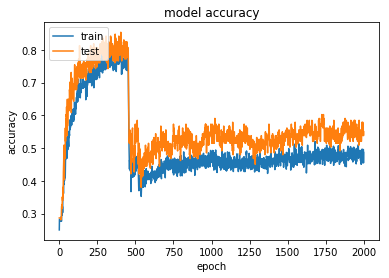

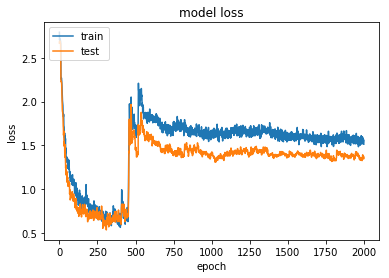

In [21]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()